<a href="https://colab.research.google.com/github/ZackPashkin/CvT-convolutional-transformer-pytorch/blob/main/CvT_convolutional_transformer_pytorch_starter_wb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Jul 27 04:56:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/rishikksh20/convolution-vision-transformers.git
!pip install einops
!pip install wandb -qqq

Cloning into 'convolution-vision-transformers'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 25 (delta 9), reused 10 (delta 3), pack-reused 0
Unpacking objects: 100% (25/25), done.
     |████████████████████████████████| 1.8 MB 14.0 MB/s 
     |████████████████████████████████| 138 kB 67.1 MB/s 
     |████████████████████████████████| 133 kB 56.9 MB/s 
     |████████████████████████████████| 170 kB 70.7 MB/s 
     |████████████████████████████████| 97 kB 7.8 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 62 kB 1.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1

In [3]:
import wandb
# Log in to your W&B account
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

In [5]:
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 32 # it will take about 14gb gpu memory
epochs = 30

In [6]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


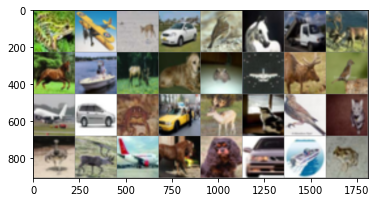

frog  plane deer  car   bird  horse truck deer  horse ship  deer  dog   frog  plane deer  bird  plane car   frog  car   deer  cat   bird  cat   bird  deer  plane horse dog   car   ship  frog 


In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [8]:
%cd "/content/convolution-vision-transformers"
from cvt import CvT
img = torch.ones([1, 3, 224, 224])

model = CvT(224, 3, 1000)
model.mlp_head[1] = nn.Linear(model.mlp_head[1].in_features, 10)


parameters = filter(lambda p: p.requires_grad, model.parameters())
parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
print('Trainable Parameters: %.3fM' % parameters)

out = model(img)

print("Output shape :", out.shape)  # [B, num_classes]

/content/convolution-vision-transformers
Trainable Parameters: 20.006M
Output shape : torch.Size([1, 1000])


In [10]:
# test
dummy_x = torch.randn(1, 3, 224, 224)
logits = model(dummy_x) 
model = model.to(device)
print(logits.shape)


torch.Size([1, 10])


In [11]:
# model description
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable

from collections import OrderedDict
import numpy as np

model = model
input_size = (3,224,224)
batch_size= 128
device="cuda"

def register_hook(module):

    def hook(module, input, output):
        class_name = str(module.__class__).split(".")[-1].split("'")[0]
        module_idx = len(summary)

        m_key = "%s-%i" % (class_name, module_idx + 1)
        summary[m_key] = OrderedDict()
        summary[m_key]["input_shape"] = list(input[0].size())
        summary[m_key]["input_shape"][0] = batch_size
        if isinstance(output, (list, tuple)):
            summary[m_key]["output_shape"] = [
                [-1] + list(o.size())[1:] for o in output
            ]
        else:
            summary[m_key]["output_shape"] = list(output.size())
            summary[m_key]["output_shape"][0] = batch_size

        params = 0
        if hasattr(module, "weight") and hasattr(module.weight, "size"):
            params += torch.prod(torch.LongTensor(list(module.weight.size())))
            summary[m_key]["trainable"] = module.weight.requires_grad
        if hasattr(module, "bias") and hasattr(module.bias, "size"):
            params += torch.prod(torch.LongTensor(list(module.bias.size())))
        summary[m_key]["nb_params"] = params

    if (
        not isinstance(module, nn.Sequential)
        and not isinstance(module, nn.ModuleList)
        and not (module == model)
    ):
        hooks.append(module.register_forward_hook(hook))

device = device.lower()
assert device in [
    "cuda",
    "cpu",
], "Input device is not valid, please specify 'cuda' or 'cpu'"

if device == "cuda" and torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

# multiple inputs to the network
if isinstance(input_size, tuple):
    input_size = [input_size]

# batch_size of 2 for batchnorm
x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
# print(type(x[0]))

# create properties
summary = OrderedDict()
hooks = []

# register hook
model.apply(register_hook)

# make a forward pass
# print(x.shape)
model(*x)

# remove these hooks
for h in hooks:
    h.remove()

print("----------------------------------------------------------------")
line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
print(line_new)
print("================================================================")
total_params = 0
total_output = 0
trainable_params = 0
for layer in summary:
    # input_shape, output_shape, trainable, nb_params
    line_new = "{:>20}  {:>25} {:>15}".format(
        layer,
        str(summary[layer]["output_shape"]),
        "{0:,}".format(summary[layer]["nb_params"]),
    )
    total_params += summary[layer]["nb_params"]
    total_output += np.prod(summary[layer]["output_shape"])
    if "trainable" in summary[layer]:
        if summary[layer]["trainable"] == True:
            trainable_params += summary[layer]["nb_params"]
    print(line_new)

# assume 4 bytes/number (float on cuda).
total_input_size = abs(np.prod(input_size) * batch_size * 4. / (1024 ** 2.))
total_output_size = abs(2. * total_output * 4. / (1024 ** 2.))  # x2 for gradients
total_params_size = abs(total_params.numpy() * 4. / (1024 ** 2.))
total_size = total_params_size + total_output_size + total_input_size


summary_df = pd.DataFrame({"Total params": int(total_params),
                   "Trainable params": int(trainable_params),
                   "Non-trainable params": int(total_params - trainable_params),
                   "Input size (MB)": total_input_size,
                   "Forward/backward pass size (MB)":total_output_size,
                   "Params size (MB)":total_params_size,
                   "Estimated Total Size (MB)": total_size},index=[0]).reset_index(drop=True).T

summary_df

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 64, 56, 56]           9,472
         Rearrange-2            [128, 3136, 64]               0
         LayerNorm-3            [128, 3136, 64]             128
         LayerNorm-4            [128, 3136, 64]             128
            Conv2d-5          [128, 64, 56, 56]             640
       BatchNorm2d-6          [128, 64, 56, 56]             128
            Conv2d-7          [128, 64, 56, 56]           4,160
         SepConv2d-8          [128, 64, 56, 56]               0
            Conv2d-9          [128, 64, 56, 56]             640
      BatchNorm2d-10          [128, 64, 56, 56]             128
           Conv2d-11          [128, 64, 56, 56]           4,160
        SepConv2d-12          [128, 64, 56, 56]               0
           Conv2d-13          [128, 64, 56, 56]             640
      BatchNorm2d-14          [128, 64,

,0
Total params,1.962465e+07
Trainable params,1.962465e+07
Non-trainable params,0.000000e+00
Input size (MB),7.350000e+01
Forward/backward pass size (MB),4.354626e+04
Params size (MB),7.486210e+01
Estimated Total Size (MB),4.369462e+04


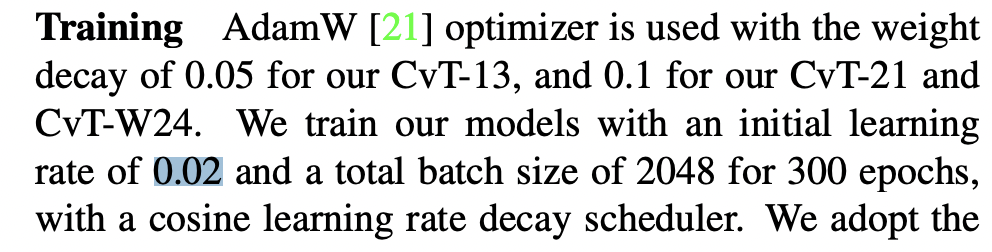

In [12]:
import torch.optim as optim
# lr = 1e-3 for 2048 batch
lr = 5e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
exp_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0, last_epoch=-1, verbose=True)

Adjusting learning rate of group 0 to 5.0000e-04.


In [13]:
# Start a run, tracking hyperparameters
wandb.init(
  project="resnet50 vs swin transformer tiny",
  config={
      "summary": summary_df,
      "optimizer": optimizer,
      "loss": criterion,
      "learning rate": lr,
      "metric": "accuracy",
      "epoch": epochs,
      "batch_size": batch_size,
  })
config = wandb.config

wandb: Currently logged in as: zack_ (use `wandb login --relogin` to force relogin)


In [ ]:
from tqdm.notebook import tqdm
from time import time

for epoch in tqdm(range(epochs), "Epoch: "): 
    model.train()
    start = time()


    running_loss = 0.0
    tqdm_train = tqdm(enumerate(trainloader, 0), "Train step: ", total=len(trainloader))
    for i, data in tqdm_train:

        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        tqdm_train.set_postfix(loss=loss.item())
        
    # update lr scheduler 
    exp_lr_scheduler.step()

    epoch_time = time() - start
    print(f"Epoch time: {epoch_time/60:.3f} min" )
    print(f"Epoch {epoch + 1} Train loss: {running_loss / len(trainloader):.3f}")

    len_trainloader = len(trainloader)
    wandb.log({"Epoch":epoch + 1,
               "Epoch time": epoch_time/60,
               "Train loss":running_loss/len_trainloader,
               })
    
    running_loss = 0.0
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    with torch.no_grad():
        model.eval()
        tqdm_val = tqdm(enumerate(valloader, 0), "Val step: ", total=len(valloader))
        for i, data in tqdm_val:
            inputs, labels = data[0].to(device), data[1].to(device)  
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # print statistics
            running_loss += loss.item()
            tqdm_val.set_postfix(loss=loss.item())
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in list(zip(labels, predictions)):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1 
               
    # print accuracy for each class
    accuracy_sum = []
    classnames = []
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        accuracy_sum.append(accuracy)
        classnames.append(classname)
        print(f"Accuracy for class {classname}: {accuracy:.1f}%")  
        
    classnames_accuracy = list(zip(classnames,accuracy_sum))

    print(f"Epoch {epoch + 1} Val loss: {running_loss / len(valloader):.3f}")
    print(f"Total accuracy: {sum(accuracy_sum)/len(accuracy_sum)}")

    len_valloader = len(valloader)
    wandb.log({"Epoch":epoch + 1, 
               "Val loss":running_loss / len_valloader,
               "Accuracy by class": classnames_accuracy,
               "Total accuracy": sum(accuracy_sum)/len(accuracy_sum),
               })

# Mark the run as finished
wandb.finish()
print('Training comleted')

Adjusting learning rate of group 0 to 4.9863e-04.


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Epoch time: 18.730 min
Epoch 1 Train loss: 1.912



Accuracy for class plane: 52.7%
Accuracy for class car: 50.4%
Accuracy for class bird: 6.5%
Accuracy for class cat: 1.7%
Accuracy for class deer: 32.1%
Accuracy for class dog: 37.3%
Accuracy for class frog: 30.7%
Accuracy for class horse: 57.4%
Accuracy for class ship: 43.1%
Accuracy for class truck: 42.6%
Epoch 1 Val loss: 1.734
Total accuracy: 35.45
Adjusting learning rate of group 0 to 4.9454e-04.


In [ ]:
# NOTE!
# gpu load 13923MiB , batch 32

In [ ]:
PATH = './model.pt'
torch.save(model.state_dict(), PATH)

In [ ]:
dataiter = iter(valloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
net.load_state_dict(torch.load(PATH))

In [ ]:
outputs = model(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

# Reference


https://github.com/rishikksh20/convolution-vision-transformers.git

https://arxiv.org/abs/2103.15808